## Method #1 VOD Logit Benchmark

In [1]:
import pandas as pd
import numpy as np

import scipy
import statsmodels.formula.api as smf
import statistics as st 
import pandas as pd
import matplotlib.pyplot as plt
from time import time

In [14]:
cd

/Users/karatechop


In [15]:
cd /Users/karatechop/Documents/GitHub/senior-thesis-pretextual-stops/Data/RIPA-DATA-CA-as-of-2022\ \(CSV\)

/Users/karatechop/Documents/GitHub/senior-thesis-pretextual-stops/Data/RIPA-DATA-CA-as-of-2022 (CSV)


In [58]:
df = pd.read_csv('working_main_expanded.csv')
print(df.columns,'\n',df.shape)

Index(['date', 'time', 'sex', 'race', 'type', 'duration', 'agency', 'location',
       'city', 'lat', 'lon', 'wave', 'sunsettime', 'mins_sunset',
       'mins_stop_time', 'mins_after_sunset', 'day_in_year'],
      dtype='object') 
 (2408246, 17)


In [65]:
vod = df[(df['type']!='Non-Moving') &
         ((df['mins_stop_time']>=990) & (df['mins_stop_time']<=1200)) & #filtering for ITP
         ((df['mins_after_sunset']<=-30) | (df['mins_after_sunset']>=0))][['date', #removing sunset->dusk period
                                                                           'race',
                                                                           'location',
                                                                           'city',
                                                                           'mins_stop_time',
                                                                           'mins_sunset']]

vod.shape

(292828, 6)

In [66]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
vod['mins_stop_time'].describe()

count   292828.000
mean      1087.188
std         61.490
min        990.000
25%       1034.000
50%       1081.000
75%       1139.000
max       1200.000
Name: mins_stop_time, dtype: float64

### Statewide VOD Model

In [77]:
vod.columns

Index(['date', 'race', 'location', 'city', 'mins_stop_time', 'mins_sunset'], dtype='object')

In [90]:
#https://www.geeksforgeeks.org/ml-one-hot-encoding-of-datasets-in-python/
vod_one_encoded = pd.get_dummies(vod, columns = ['race'], drop_first=True, prefix='')\
                    [['date', 
                      'location', 
                      'city', 
                      'mins_stop_time', 
                      'mins_sunset',
                      '_black/african american']].rename(columns={'_black/african american':'black'})\
                                                 .reset_index(drop=True)
vod_one_encoded

,date,location,city,mins_stop_time,mins_sunset,black
0,2021-03-12 00:00:00,1100 block of william ct - San Jose,San Jose,1054.000,1092.000,0
1,2021-01-30 00:00:00,1300 block of sthal street - San Jose,San Jose,1050.000,1050.000,0
2,2021-11-16 00:00:00,1400 block of airport blvd - San Jose,San Jose,1025.000,1016.000,0
3,2021-03-30 00:00:00,1600 block of almaden ex - San Jose,San Jose,1183.000,1169.000,0
4,2021-11-01 00:00:00,1600 block of saratoga av - San Jose,San Jose,1020.000,1089.000,0
...,...,...,...,...,...,...
292823,2021-12-30 00:00:00,TNC1 and McDonnell RD - San Francisco,San Francisco,1095.000,1020.000,0
292824,2021-12-30 00:00:00,ULLOA ST / 19TH AVE - San Francisco,San Francisco,1169.000,1020.000,0
292825,2021-12-30 00:00:00,STOCKTON ST / OFARRELL ST - San Francisco,San Francisco,1157.000,1020.000,0
292826,2021-12-30 00:00:00,Trillium Lot and McDonnell Rd - San Francisco,San Francisco,1175.000,1020.000,0


In [94]:
# city = [city for city in vod['city'].value_counts().rename_axis('city').reset_index(name='count')['city']]

formula = f"black ~ C({agency}, Treatment(reference=0)) + C({city}, Treatment(reference=0))"
log_reg = smf.logit(formula, data = df).fit()
results = log_reg.summary()
OR = pd.DataFrame(
    {
        "OR": log_reg.params,
        "Lower CI": log_reg.conf_int()[0],
        "Upper CI": log_reg.conf_int()[1],
    },
)
OR = np.exp(OR)

print(f"\n\n{race} model (LARGE)\n{OR}\n\n\n{results}\n\n\n\n\n\n\n\n\n")

In [ ]:
race_options = ['white','black','hispanic','asian','report_risk_groups','bipoc']


for race in race_options:
    formula = f"arrest ~ C({race}, Treatment(reference=0)) + perceivedage + C(perceivedgender, Treatment(reference=0)) + \
                C(trafficstop, Treatment(reference=0)) + tract_distancefromcal + tract_totalpop + tract_medianincome + tract_annualstops + tract_bipoccomp"
    log_reg = smf.logit(formula, data = df).fit()
    results = log_reg.summary()
    OR = pd.DataFrame(
        {
            "OR": log_reg.params,
            "Lower CI": log_reg.conf_int()[0],
            "Upper CI": log_reg.conf_int()[1],
        },
    )
    OR = np.exp(OR)
    
    print(f"\n\n{race} model (LARGE)\n{OR}\n\n\n{results}\n\n\n\n\n\n\n\n\n")


## Method #2 Proportions Before/After Sunset

In [6]:
cd

/Users/karatechop


In [7]:
cd /Users/karatechop/Documents/GitHub/senior-thesis-pretextual-stops/Data/RIPA-DATA-CA-as-of-2022\ \(CSV\)

/Users/karatechop/Documents/GitHub/senior-thesis-pretextual-stops/Data/RIPA-DATA-CA-as-of-2022 (CSV)


In [8]:
df = pd.read_csv('working_main_expanded.csv')
df.columns

Index(['date', 'time', 'sex', 'race', 'type', 'duration', 'agency', 'city',
       'lat', 'lon', 'wave', 'sunsettime', 'mins_sunset', 'mins_stop_time',
       'mins_after_sunset', 'day_in_year'],
      dtype='object')

In [9]:
# fig,ax=plt.subplots()

# ax.plot(prop_table['after_sunset_category'],prop_table['total_stops'],c='red',label='reported stops',marker="o")
# ax.set_xlabel("minutes before/after dusk")
# ax.set_ylabel('stop count',c='red')


# ax2=ax.twinx()
# ax2.plot(prop_table['after_sunset_category'],prop_table['prop'],c="blue",marker="o")
# ax2.set_ylabel("proportion black/aa",color="blue")
# plt.axvline(x = 0,c='black',alpha=.5,linestyle='dashed')
# plt.axvline(x = -30,c='black',alpha=.5,linestyle='dashed')

# plt.show()

# # https://cmdlinetips.com/2019/10/how-to-make-a-plot-with-two-different-y-axis-in-python-with-matplotlib/




# # save the plot as a file
# # fig.savefig('two_different_y_axis_for_single_python_plot_with_twinx.jpg',
# #             format='jpeg',
# #             dpi=100,
# #             bbox_inches='tight')

### CA

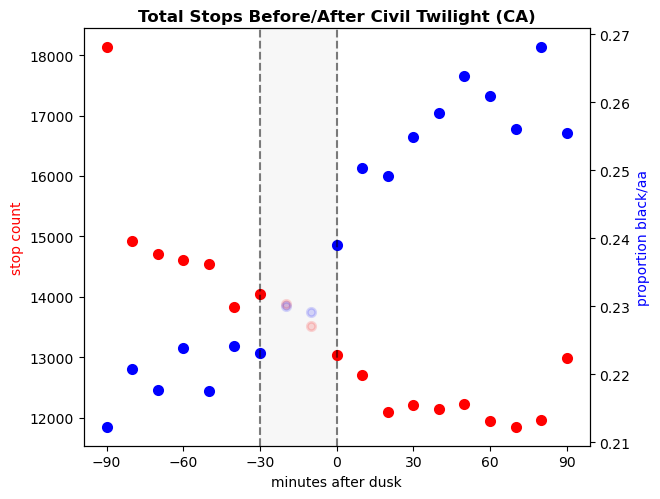

In [74]:
df = df[['date','wave','race','mins_stop_time','mins_sunset','mins_after_sunset','type','city']]
df1_bw = df[(df['mins_after_sunset'] <= 96) &\
#             ((df['race'] == 'white') | (df['race'] == 'black/african american')) &\
            (df['mins_after_sunset'] >= -96) &\
#             (df['city']=='Oakland') &\
            (df['type']=='Moving')][['date','wave','race','mins_stop_time','mins_sunset','mins_after_sunset']]

df1_bw['after_sunset_category'] = [min(np.arange(-90,91,10), key=lambda x:abs(x-i)) for i in df1_bw['mins_after_sunset']]
prop_table = df1_bw.groupby('after_sunset_category',as_index=False).agg('count')[['after_sunset_category','race']]
prop_table['black_aa'] = df1_bw[df1_bw['race']=='black/african american'].groupby('after_sunset_category',as_index=False)\
                                                                   .agg('count')[['after_sunset_category','race']]\
                                                                   .rename(columns={'race':'black_aa'})['black_aa']
prop_table['prop_black_aa'] = round(prop_table['black_aa']/prop_table['race'],4)

prop_table = prop_table.sort_values(by='after_sunset_category')\
                       .reset_index(drop=True)\
                       .rename(columns={'race':'total_stops',
                                        'black_aa':'black_aa_stops',
                                        'prop_black_aa':'prop'})

prop_table_pre = prop_table[(prop_table['after_sunset_category']<= -30)]
prop_table_post = prop_table[(prop_table['after_sunset_category']>= -1)]
prop_table_dusk = prop_table[(prop_table['after_sunset_category']>= -30) & (prop_table['after_sunset_category']<= 0)]


fig,ax=plt.subplots()

ax.scatter(prop_table_pre['after_sunset_category'],prop_table_pre['total_stops'],linewidth=2,c='red',label='reported stops',marker="o")
ax.scatter(prop_table_post['after_sunset_category'],prop_table_post['total_stops'],linewidth=2,c='red',label='reported stops',marker="o")
ax.scatter(prop_table_dusk['after_sunset_category'],prop_table_dusk['total_stops'],linewidth=2,c='red',alpha=.15,marker="o")

ax.set_xlabel("minutes after dusk")
ax.set_ylabel('stop count',c='red')


ax2=ax.twinx()
ax2.scatter(prop_table_pre['after_sunset_category'],prop_table_pre['prop'],linewidth=2,c="blue",marker="o")
ax2.scatter(prop_table_post['after_sunset_category'],prop_table_post['prop'],linewidth=2,c="blue",marker="o")
ax2.scatter(prop_table_dusk['after_sunset_category'],prop_table_dusk['prop'],linewidth=2,c='blue',alpha=.15,marker="o")

ax2.set_ylabel("proportion black/aa",color="blue")


plt.xticks(np.arange(-90,95,30))
plt.axvline(x = 0,c='black',alpha=.5,linestyle='dashed')
plt.axvline(x = -30,c='black',alpha=.5,linestyle='dashed')
plt.axvspan(-30, 0, color='black', alpha=0.03)

plt.title('Total Stops Before/After Civil Twilight (CA)',weight='semibold',pad=5)
plt.tight_layout(pad=0, w_pad=2, h_pad=2)

plt.show()


# save the plot as a file
fig.savefig('/Users/karatechop/Documents/GitHub/senior-thesis-pretextual-stops/Notebooks/Exports/Total Stops vs Proportion Black Civil Twilight (CA).jpg',
            format='jpeg',
            dpi=100,
            bbox_inches='tight')

### WAVE 1

In [65]:
df1_bw.race.unique()[0::2]

array(['white', 'asian', 'group 4'], dtype=object)

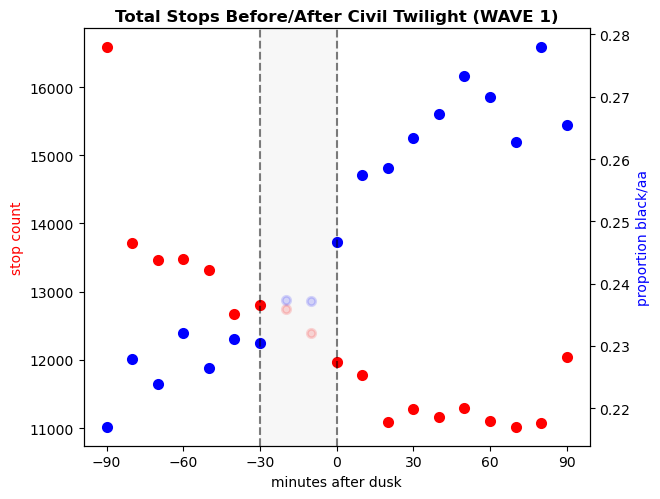

In [57]:
wave = 1

df = df[['date','wave','race','mins_stop_time','mins_sunset','mins_after_sunset','type','city']]
df1_bw = df[(df['mins_after_sunset'] <= 96) &\
            (df['mins_after_sunset'] >= -96) &\
            (df['wave']==wave) &\
            (df['type']=='Moving')][['date','wave','race','mins_stop_time','mins_sunset','mins_after_sunset']]

df1_bw['after_sunset_category'] = [min(np.arange(-90,91,10), key=lambda x:abs(x-i)) for i in df1_bw['mins_after_sunset']]
prop_table = df1_bw.groupby('after_sunset_category',as_index=False).agg('count')[['after_sunset_category','race']]
prop_table['black_aa'] = df1_bw[df1_bw['race']=='black/african american'].groupby('after_sunset_category',as_index=False)\
                                                                   .agg('count')[['after_sunset_category','race']]\
                                                                   .rename(columns={'race':'black_aa'})['black_aa']
prop_table['prop_black_aa'] = round(prop_table['black_aa']/prop_table['race'],4)

prop_table = prop_table.sort_values(by='after_sunset_category')\
                       .reset_index(drop=True)\
                       .rename(columns={'race':'total_stops',
                                        'black_aa':'black_aa_stops',
                                        'prop_black_aa':'prop'})

prop_table_pre = prop_table[(prop_table['after_sunset_category']<= -30)]
prop_table_post = prop_table[(prop_table['after_sunset_category']>= -1)]
prop_table_dusk = prop_table[(prop_table['after_sunset_category']>= -30) & (prop_table['after_sunset_category']<= 0)]


fig,ax=plt.subplots()

ax.scatter(prop_table_pre['after_sunset_category'],prop_table_pre['total_stops'],linewidth=2,c='red',label='reported stops',marker="o")
ax.scatter(prop_table_post['after_sunset_category'],prop_table_post['total_stops'],linewidth=2,c='red',label='reported stops',marker="o")
ax.scatter(prop_table_dusk['after_sunset_category'],prop_table_dusk['total_stops'],linewidth=2,c='red',alpha=.15,marker="o")

ax.set_xlabel("minutes after dusk")
ax.set_ylabel('stop count',c='red')


ax2=ax.twinx()
ax2.scatter(prop_table_pre['after_sunset_category'],prop_table_pre['prop'],linewidth=2,c="blue",marker="o")
ax2.scatter(prop_table_post['after_sunset_category'],prop_table_post['prop'],linewidth=2,c="blue",marker="o")
ax2.scatter(prop_table_dusk['after_sunset_category'],prop_table_dusk['prop'],linewidth=2,c='blue',alpha=.15,marker="o")

ax2.set_ylabel("proportion black/aa",color="blue")



plt.xticks(np.arange(-90,95,30))
plt.axvline(x = 0,c='black',alpha=.5,linestyle='dashed')
plt.axvline(x = -30,c='black',alpha=.5,linestyle='dashed')
plt.axvspan(-30, 0, color='black', alpha=0.03)

plt.title(f'Total Stops Before/After Civil Twilight (WAVE {wave})',weight='semibold',pad=5)
plt.tight_layout(pad=0, w_pad=2, h_pad=2)

plt.show()






# save the plot as a file
fig.savefig(f'/Users/karatechop/Documents/GitHub/senior-thesis-pretextual-stops/Notebooks/Exports/Total Stops vs Proportion Black Civil Twilight (WAVE {wave}).jpg',
            format='jpeg',
            dpi=100,
            bbox_inches='tight')

### WAVE 2

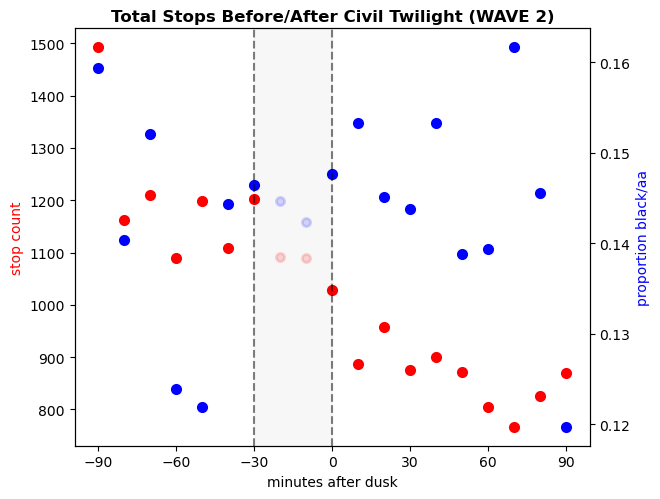

In [12]:
wave = 2

df = df[['date','wave','race','mins_stop_time','mins_sunset','mins_after_sunset','type','city']]
df1_bw = df[(df['mins_after_sunset'] <= 96) &\
            (df['mins_after_sunset'] >= -96) &\
            (df['wave']==wave) &\
            (df['type']=='Moving')][['date','wave','race','mins_stop_time','mins_sunset','mins_after_sunset']]

df1_bw['after_sunset_category'] = [min(np.arange(-90,91,10), key=lambda x:abs(x-i)) for i in df1_bw['mins_after_sunset']]
prop_table = df1_bw.groupby('after_sunset_category',as_index=False).agg('count')[['after_sunset_category','race']]
prop_table['black_aa'] = df1_bw[df1_bw['race']=='black/african american'].groupby('after_sunset_category',as_index=False)\
                                                                   .agg('count')[['after_sunset_category','race']]\
                                                                   .rename(columns={'race':'black_aa'})['black_aa']
prop_table['prop_black_aa'] = round(prop_table['black_aa']/prop_table['race'],4)

prop_table = prop_table.sort_values(by='after_sunset_category')\
                       .reset_index(drop=True)\
                       .rename(columns={'race':'total_stops',
                                        'black_aa':'black_aa_stops',
                                        'prop_black_aa':'prop'})

prop_table_pre = prop_table[(prop_table['after_sunset_category']<= -30)]
prop_table_post = prop_table[(prop_table['after_sunset_category']>= -1)]
prop_table_dusk = prop_table[(prop_table['after_sunset_category']>= -30) & (prop_table['after_sunset_category']<= 0)]


fig,ax=plt.subplots()

ax.scatter(prop_table_pre['after_sunset_category'],prop_table_pre['total_stops'],linewidth=2,c='red',label='reported stops',marker="o")
ax.scatter(prop_table_post['after_sunset_category'],prop_table_post['total_stops'],linewidth=2,c='red',label='reported stops',marker="o")
ax.scatter(prop_table_dusk['after_sunset_category'],prop_table_dusk['total_stops'],linewidth=2,c='red',alpha=.15,marker="o")

ax.set_xlabel("minutes after dusk")
ax.set_ylabel('stop count',c='red')


ax2=ax.twinx()
ax2.scatter(prop_table_pre['after_sunset_category'],prop_table_pre['prop'],linewidth=2,c="blue",marker="o")
ax2.scatter(prop_table_post['after_sunset_category'],prop_table_post['prop'],linewidth=2,c="blue",marker="o")
ax2.scatter(prop_table_dusk['after_sunset_category'],prop_table_dusk['prop'],linewidth=2,c='blue',alpha=.15,marker="o")

ax2.set_ylabel("proportion black/aa",color="blue")


plt.xticks(np.arange(-90,95,30))
plt.axvline(x = 0,c='black',alpha=.5,linestyle='dashed')
plt.axvline(x = -30,c='black',alpha=.5,linestyle='dashed')
plt.axvspan(-30, 0, color='black', alpha=0.03)

plt.title(f'Total Stops Before/After Civil Twilight (WAVE {wave})',weight='semibold',pad=5)
plt.tight_layout(pad=0, w_pad=2, h_pad=2)

plt.show()






# save the plot as a file
fig.savefig(f'/Users/karatechop/Documents/GitHub/senior-thesis-pretextual-stops/Notebooks/Exports/Total Stops vs Proportion Black Civil Twilight (WAVE {wave}).jpg',
            format='jpeg',
            dpi=100,
            bbox_inches='tight')

### WAVE 3

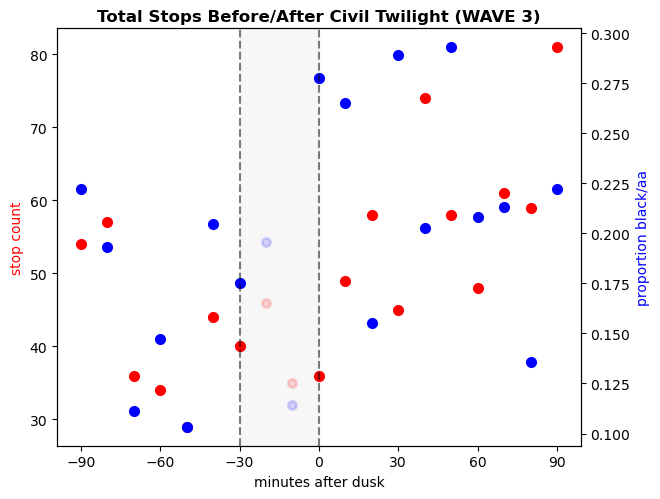

In [13]:
wave = 3

df = df[['date','wave','race','mins_stop_time','mins_sunset','mins_after_sunset','type','city']]
df1_bw = df[(df['mins_after_sunset'] <= 96) &\
            (df['mins_after_sunset'] >= -96) &\
            (df['wave']==wave) &\
            (df['type']=='Moving')][['date','wave','race','mins_stop_time','mins_sunset','mins_after_sunset']]

df1_bw['after_sunset_category'] = [min(np.arange(-90,91,10), key=lambda x:abs(x-i)) for i in df1_bw['mins_after_sunset']]
prop_table = df1_bw.groupby('after_sunset_category',as_index=False).agg('count')[['after_sunset_category','race']]
prop_table['black_aa'] = df1_bw[df1_bw['race']=='black/african american'].groupby('after_sunset_category',as_index=False)\
                                                                   .agg('count')[['after_sunset_category','race']]\
                                                                   .rename(columns={'race':'black_aa'})['black_aa']
prop_table['prop_black_aa'] = round(prop_table['black_aa']/prop_table['race'],4)

prop_table = prop_table.sort_values(by='after_sunset_category')\
                       .reset_index(drop=True)\
                       .rename(columns={'race':'total_stops',
                                        'black_aa':'black_aa_stops',
                                        'prop_black_aa':'prop'})

prop_table_pre = prop_table[(prop_table['after_sunset_category']<= -30)]
prop_table_post = prop_table[(prop_table['after_sunset_category']>= -1)]
prop_table_dusk = prop_table[(prop_table['after_sunset_category']>= -30) & (prop_table['after_sunset_category']<= 0)]


fig,ax=plt.subplots()

ax.scatter(prop_table_pre['after_sunset_category'],prop_table_pre['total_stops'],linewidth=2,c='red',label='reported stops',marker="o")
ax.scatter(prop_table_post['after_sunset_category'],prop_table_post['total_stops'],linewidth=2,c='red',label='reported stops',marker="o")
ax.scatter(prop_table_dusk['after_sunset_category'],prop_table_dusk['total_stops'],linewidth=2,c='red',alpha=.15,marker="o")

ax.set_xlabel("minutes after dusk")
ax.set_ylabel('stop count',c='red')


ax2=ax.twinx()
ax2.scatter(prop_table_pre['after_sunset_category'],prop_table_pre['prop'],linewidth=2,c="blue",marker="o")
ax2.scatter(prop_table_post['after_sunset_category'],prop_table_post['prop'],linewidth=2,c="blue",marker="o")
ax2.scatter(prop_table_dusk['after_sunset_category'],prop_table_dusk['prop'],linewidth=2,c='blue',alpha=.15,marker="o")

ax2.set_ylabel("proportion black/aa",color="blue")


plt.xticks(np.arange(-90,95,30))
plt.axvline(x = 0,c='black',alpha=.5,linestyle='dashed')
plt.axvline(x = -30,c='black',alpha=.5,linestyle='dashed')
plt.axvspan(-30, 0, color='black', alpha=0.03)

plt.title(f'Total Stops Before/After Civil Twilight (WAVE {wave})',weight='semibold',pad=5)
plt.tight_layout(pad=0, w_pad=2, h_pad=2)

plt.show()






# save the plot as a file
fig.savefig(f'/Users/karatechop/Documents/GitHub/senior-thesis-pretextual-stops/Notebooks/Exports/Total Stops vs Proportion Black Civil Twilight (WAVE {wave}).jpg',
            format='jpeg',
            dpi=100,
            bbox_inches='tight')

### Check overall race increase/decreases around ITP

In [14]:
cd

/Users/karatechop


In [15]:
cd /Users/karatechop/Documents/GitHub/senior-thesis-pretextual-stops/Data/RIPA-DATA-CA-as-of-2022\ \(CSV\)

/Users/karatechop/Documents/GitHub/senior-thesis-pretextual-stops/Data/RIPA-DATA-CA-as-of-2022 (CSV)


In [16]:
hour_test = pd.read_csv('working_main_expanded.csv')
hour_test.columns

Index(['date', 'time', 'sex', 'race', 'type', 'duration', 'agency', 'city',
       'lat', 'lon', 'wave', 'sunsettime', 'mins_sunset', 'mins_stop_time',
       'mins_after_sunset', 'day_in_year'],
      dtype='object')

In [17]:
hour_test.race.value_counts()

hispanic/latino(a)        1062240
white                      563645
black/african american     538390
group 4                    177537
asian                      121642
Name: race, dtype: int64

In [18]:
hour_test.time = pd.to_datetime(hour_test.time)

In [19]:
hour_test['hour'] = [i.hour for i in hour_test.time]

In [20]:
60*20

1200

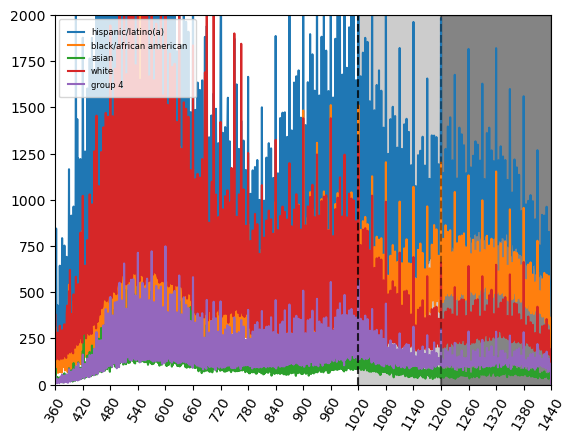

In [29]:
grouped_hours = hour_test[(hour_test['mins_stop_time']>=(60*15))&(hour_test['mins_stop_time']<=(60*22))]
plt.xticks(np.arange(0,(60*24.5),60),rotation=60)

for i in hour_test.race.unique():
    grouped_hours = hour_test[hour_test['race']==i].groupby('mins_stop_time',as_index=False).agg('count')[['mins_stop_time','race']]
    plt.plot(grouped_hours.mins_stop_time,grouped_hours.race,label=f'{i}')

# plt.axvline(x = 1020,c='black',alpha=.8,linestyle='dashed')
# plt.axvline(x = 1200,c='black',alpha=.8,linestyle='dashed')
# plt.axvspan(0, 1020, color='black', alpha=0.2)
# plt.axvspan(1200, 1440, color='black', alpha=0.2)
plt.axvline(x = 1020,c='black',alpha=.8,linestyle='dashed')
plt.axvspan(1020, 1440, color='black', alpha=0.2)

plt.axvline(x = 1200,c='black',alpha=.4,linestyle='dashed')
plt.axvspan(1200, 1440, color='black', alpha=0.35)

plt.xlim(360,1440)
plt.ylim(0,2000)

plt.legend(fontsize=6,borderpad=1,loc='upper left')

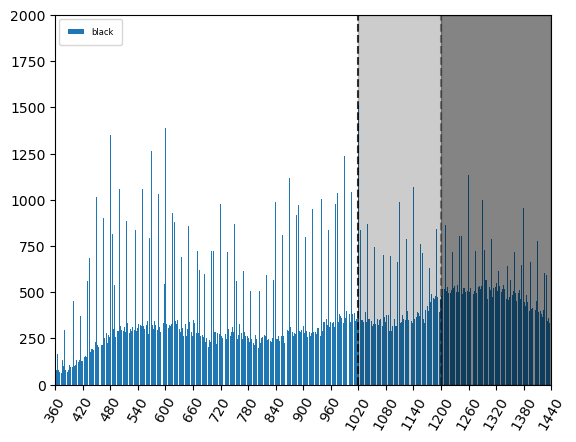

In [28]:
grouped_hours = hour_test[(hour_test['mins_stop_time']>=(60*15))&(hour_test['mins_stop_time']<=(60*22))]
plt.xticks(np.arange(0,(60*24.5),60),rotation=60)

# for i in hour_test.race.unique():
grouped_hours = hour_test[hour_test['race']=='black/african american'].groupby('mins_stop_time',as_index=False).agg('count')[['mins_stop_time','race']]
plt.bar(grouped_hours.mins_stop_time,grouped_hours.race,label='black')

# plt.axvline(x = 1020,c='black',alpha=.8,linestyle='dashed')
# plt.axvline(x = 1200,c='black',alpha=.8,linestyle='dashed')
# plt.axvspan(0, 1020, color='black', alpha=0.2)
# plt.axvspan(1200, 1440, color='black', alpha=0.2)
plt.axvline(x = 1020,c='black',alpha=.8,linestyle='dashed')
plt.axvspan(1020, 1440, color='black', alpha=0.2)

plt.axvline(x = 1200,c='black',alpha=.4,linestyle='dashed')
plt.axvspan(1200, 1440, color='black', alpha=0.35)

plt.xlim(360,1440)
plt.ylim(0,2000)

plt.legend(fontsize=6,borderpad=1,loc='upper left')

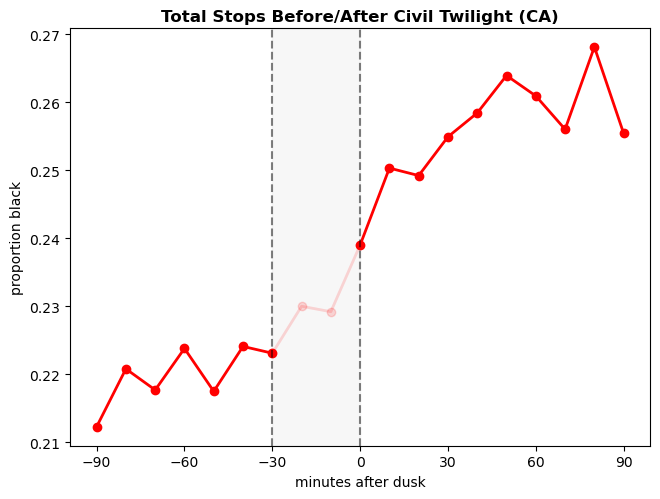

In [40]:
df = df[['date','wave','race','mins_stop_time','mins_sunset','mins_after_sunset','type','city']]
df1_bw = df[(df['mins_after_sunset'] <= 96) &\
            (df['mins_after_sunset'] >= -96) &\
#             (df['city']=='Los Angeles') &\
            (df['type']=='Moving')][['date','wave','race','mins_stop_time','mins_sunset','mins_after_sunset']]

df1_bw['after_sunset_category'] = [min(np.arange(-90,91,10), key=lambda x:abs(x-i)) for i in df1_bw['mins_after_sunset']]
prop_table = df1_bw.groupby('after_sunset_category',as_index=False).agg('count')[['after_sunset_category','race']]

prop_table['black_aa'] = df1_bw[df1_bw['race']=='black/african american'].groupby('after_sunset_category',as_index=False)\
                                                                   .agg('count')[['after_sunset_category','race']]\
                                                                   .rename(columns={'race':'black_aa'})['black_aa']
prop_table['prop_black_aa'] = round(prop_table['black_aa']/prop_table['race'],4)

prop_table = prop_table.sort_values(by='after_sunset_category')\
                       .reset_index(drop=True)\
                       .rename(columns={'race':'total_stops',
                                        'black_aa':'black_aa_stops',
                                        'prop_black_aa':'prop'})

prop_table_pre = prop_table[(prop_table['after_sunset_category']<= -30)]
prop_table_post = prop_table[(prop_table['after_sunset_category']>= -1)]
prop_table_dusk = prop_table[(prop_table['after_sunset_category']>= -30) & (prop_table['after_sunset_category']<= 0)]


fig,ax=plt.subplots()

ax.plot(prop_table_pre['after_sunset_category'],prop_table_pre['prop'],linewidth=2,c='red',label='reported stops',marker="o")
ax.plot(prop_table_post['after_sunset_category'],prop_table_post['prop'],linewidth=2,c='red',label='reported stops',marker="o")
ax.plot(prop_table_dusk['after_sunset_category'],prop_table_dusk['prop'],linewidth=2,c='red',alpha=.15,marker="o")

ax.set_xlabel("minutes after dusk")
ax.set_ylabel("proportion black")


plt.xticks(np.arange(-90,95,30),c='red')
plt.axvline(x = 0,c='black',alpha=.5,linestyle='dashed')
plt.axvline(x = -30,c='black',alpha=.5,linestyle='dashed')
plt.axvspan(-30, 0, color='black', alpha=0.03)

plt.title('Total Stops Before/After Civil Twilight (CA)',weight='semibold',pad=5)
plt.tight_layout(pad=0, w_pad=2, h_pad=2)

plt.show()






# save the plot as a file
# fig.savefig('/Users/karatechop/Documents/GitHub/senior-thesis-pretextual-stops/Notebooks/Exports/Total Stops vs Proportion Black Civil Twilight (CA).jpg',
#             format='jpeg',
#             dpi=100,
#             bbox_inches='tight')

In [38]:
prop_table

,after_sunset_category,total_stops,black_aa_stops,prop
0,-90,18135,3850,0.2123
1,-80,14931,3297,0.2208
2,-70,14713,3203,0.2177
3,-60,14610,3270,0.2238
4,-50,14545,3164,0.2175
5,-40,13825,3098,0.2241
6,-30,14052,3135,0.2231
7,-20,13881,3192,0.2300
8,-10,13517,3098,0.2292
9,0,13031,3114,0.2390
